In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import ShortTimeFFT, windows
import librosa
import torch

In [3]:
from sklearn.preprocessing import LabelEncoder

/Users/maxiabdala/opt/anaconda3/envs/seriesTemporales/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


'cpu'

## Lectura de datos 

In [5]:
os.chdir('/Users/maxiabdala/Documents/Python/repositorio Maxi/series_temporales_maxi/trabajo_final/codigo')

In [6]:
# vemos los archivos de audio
data_folder = os.path.join('data', 'train')  # carpeta del training set
classes_folders = os.listdir(data_folder)                   # carpeta de cada clase

# Creamos un diccionario para cada clase donde pondremos los audios
data = {}
for c in classes_folders:
    if c[0] != '.':
        data[c] = data.get(c, []) # agregamos

# Llenamos una lista para cada clase con los datos
b=0
for c in classes_folders:
    if c[0] != '.':
        for f in os.listdir(os.path.join(data_folder, c)):
            path = os.path.join(data_folder, c, f)
            audio, sr = librosa.load(os.path.join(data_folder, c, f) , sr=None)  # leemos el audio como numpy array
            duracion = librosa.get_duration(y=audio, sr=sr)
            if (b):
              if (duracion<men): men=duracion
            else:
              men=duracion
              b=1
            data[c].append(audio)   # no guardamos el samplerate porque todos son iguales

# Inspección de los datos

for k in data.keys():
    print(f'La clase {k} tiene {len(data[k])} elementos')

La clase auto tiene 6 elementos
La clase moto tiene 6 elementos
La clase camioneta tiene 8 elementos
La clase colectivo tiene 10 elementos


## Preparacion de los datos
ahora hay 2 funciones distintas para armar los espectrogramas correrlas por separado y despues correr el modelo

Funcion que armo seba

In [7]:
def create_specs(x, ws, sr):
    '''Wrapper para calcular los espectrogramas de manera sencilla
    Regresa las frecuencias, los intervalos de tiempo y el espectrograma normalizado entre 0 y 1'''
    N = len(x)
    SFT = ShortTimeFFT(windows.boxcar(400), hop=400, fs=sr, scale_to='magnitude')
    ts = SFT.delta_t * np.arange(N)/ws #crea los timestamps
    Sx = SFT.spectrogram(x)  # perform the STFT
    Sx_l = np.log(Sx[:])
    Sx = (Sx_l - Sx_l.min())
    Sx /= Sx.max()

    return SFT.f, ts[::ws], Sx

In [34]:
# para hacer un entrenamiento vamos a utilizar como features los espectrogramas
ws = 220            # Ancho de la ventana temporal
spects = {}         # creamos listas vacías
for k in data.keys():
    spects[k] = spects.get(k, [])

# llenamos las listas con espectrogramas
for k in data.keys():
    for d in data[k]:
        spec = create_specs(d, ws=400, sr = 22050)
        spects[k].append(spec)

/Users/maxiabdala/opt/anaconda3/envs/seriesTemporales/lib/python3.12/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Funcion para ver los espectrogramas en frecuencias de Mel, la red neuronal trabajo mucho mas rapido con estas ventanas y converge mejor

In [66]:
def create_specs(x, ws, sr):
    '''Wrapper para calcular los espectrogramas de manera sencilla.
    Regresa las frecuencias, los intervalos de tiempo y el espectrograma normalizado entre 0 y 1'''
    # Número de bandas de frecuencia Mel
    n_mels = 128

    # Calcular el espectrograma de Mel
    S = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=ws, hop_length=ws//2, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)
    S_dB_norm = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())

    # Obtener frecuencias de Mel y timestamps
    freqs = librosa.mel_frequencies(n_mels=n_mels, fmin=0, fmax=sr/2)
    ts = librosa.frames_to_time(np.arange(S.shape[1]), sr=sr, hop_length=ws//2)
    
    return freqs, ts, S_dB_norm

In [90]:
# para hacer un entrenamiento vamos a utilizar como features los espectrogramas
sr = 22050
ws = 400       # Ancho de la ventana temporal
spects = {}         # creamos listas vacías
for k in data.keys():
    spects[k] = spects.get(k, [])

# llenamos las listas con espectrogramas
for k in data.keys():
    for d in data[k]:
        spec = create_specs(d, ws, sr)
        spects[k].append(spec)

# Para hacer un entrenamiento vamos a utilizar como features los espectrogramas


In [91]:
# poniendo todos los datos como una lista
train_x = []
labels = []
for k in spects.keys():
    for s in spects[k]:
        train_x.append(s[2])
        labels.append([k])

In [69]:
print(labels)

[['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['moto'], ['moto'], ['moto'], ['moto'], ['moto'], ['moto'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo']]


In [92]:
#obtener menor longiud para recortar espectogramas
men=train_x[0].shape[1]
for i in range (1,len(train_x)):
  if (train_x[i].shape[1]<men):
    men=train_x[i].shape[1]
print(men)

23


In [93]:
#ponemos todos los espectogramas con el mismo largo
train=[]
for i in range (len(train_x)):
  tam=train_x[i].shape[1]
  if (tam!=men):
    train.append(train_x[i][:,tam//2-men//2:tam//2+(men//2)+1])
  else:
    train.append(train_x[i])

# Printear los espectogramas


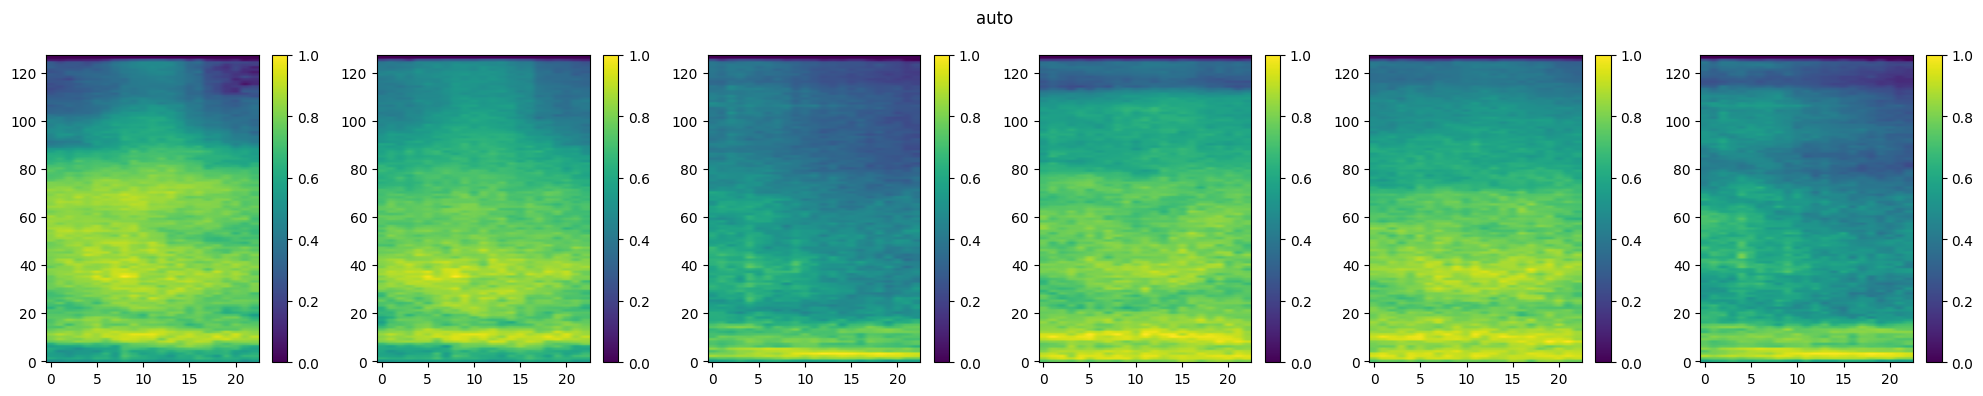

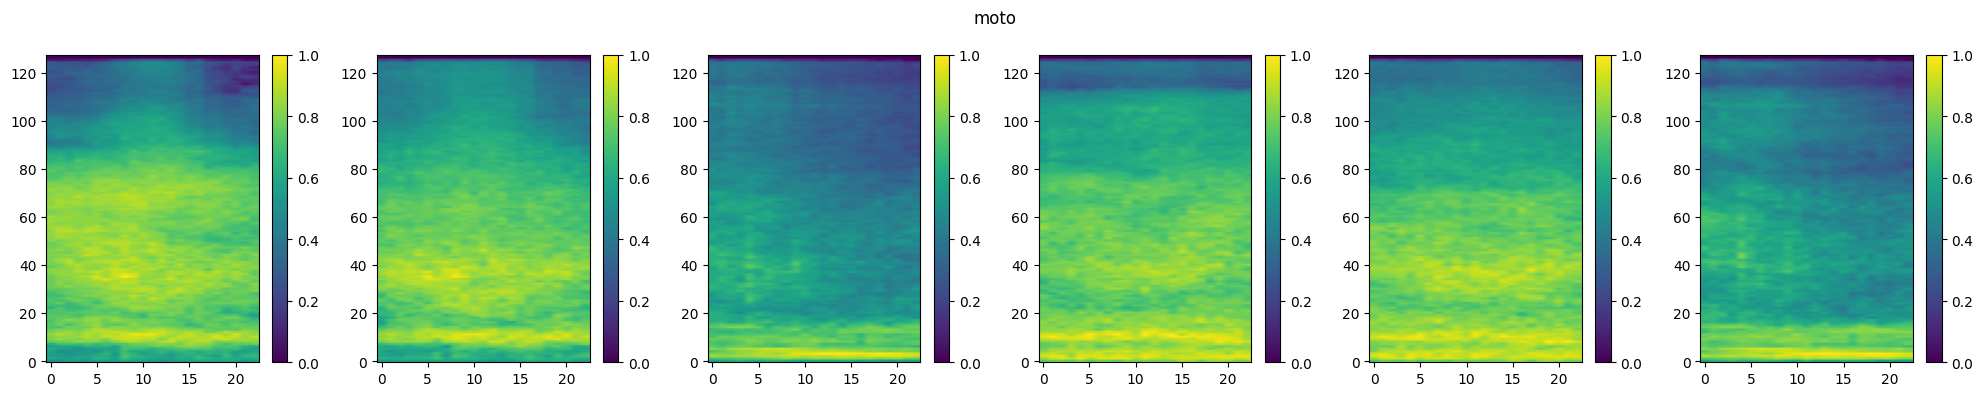

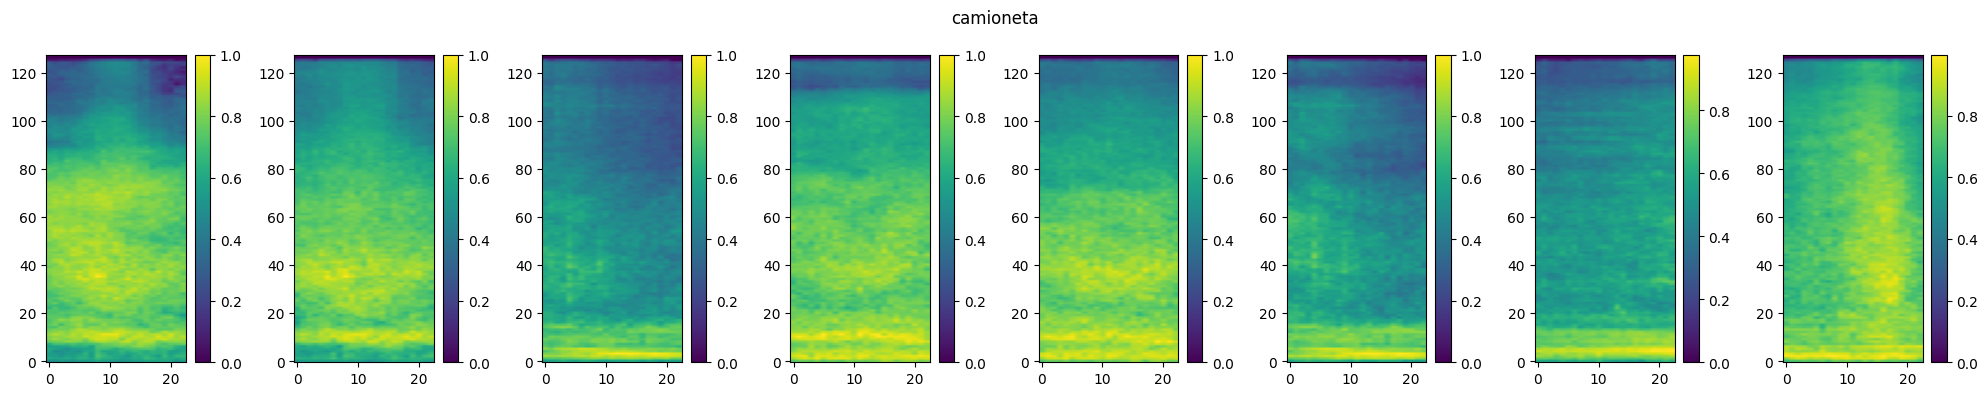

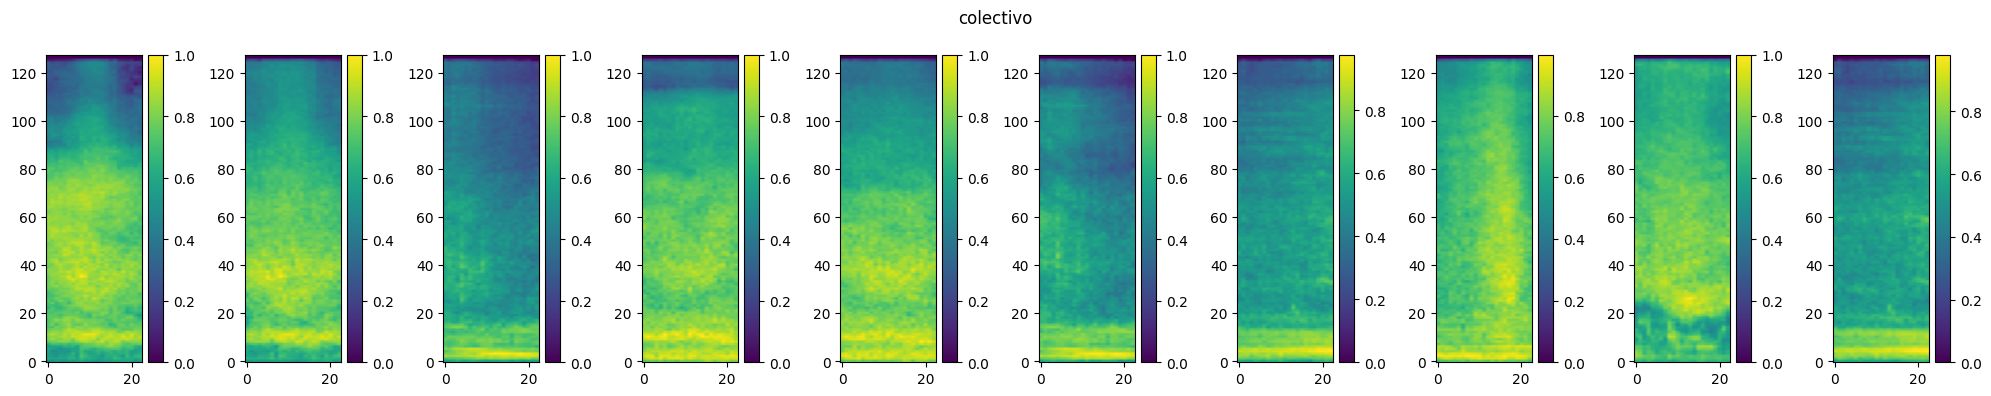

In [94]:
for k in spects.keys():
    plt.figure(figsize=(20,4))
    j=0
    for i in range(len(spects[k])):
        j+=1
        plt.subplot(1, len(spects[k]),j)
        plt.imshow(train[i], origin='lower', aspect='auto', interpolation=None) #extent=[s[1][0],s[1][-1],s[0][0], s[0][-1]],
        plt.colorbar()
    plt.suptitle(k)
    plt.tight_layout()
    plt.show()

# Model combinado CNN + LSTM

In [95]:
# Definimos un modelo
class CNN_LSTM(torch.nn.Module):
    def __init__(self, num_f,num_c):
        super().__init__()
        #********CNN********#
        self.conv1 = torch.nn.Conv2d(in_channels=1,
                                     out_channels=32,
                                     kernel_size=(3,3),
                                     padding = (1,1),
                                     stride = (1,1)
                                     )
        self.drop = torch.nn.Dropout(0.25)
        # 32, 201*111
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(2,2))
        # 32, achica en 2 la dimensión
        self.conv2 = torch.nn.Conv2d(in_channels = 32,
                                     out_channels=64,
                                     kernel_size=(3,3),
                                     stride=(1,1),
                                     padding=(1,1)
                                     )
        # 64, misma dimesión despues de max pool
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=(2,2))
        #64, achica en 2 la dimensión
        self.lin   = torch.nn.Linear(in_features = 64*(num_f//4)*(num_c//4),
                                     out_features = 32)
        #********LSTM********#
        self.lstm = torch.nn.LSTM(input_size  = 32,
                                  hidden_size = 64,
                                  num_layers  = 5,
                                  batch_first = True,
                                  bidirectional= True)
        self.fcon = torch.nn.Linear( in_features  = 2*64, #se multiplica por 2 por ser bidireccional
                                     out_features = 4)


    def forward(self, x):
        #********CNN********#
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop(x)
        x = x.flatten(0)
        x = self.lin(x)
        #********LSTM********#
        x= x[None,None,:]
        x, _ = self.lstm(x)
        x = self.fcon(x)
        return x[:,-1,:].squeeze(1) # regresamos el ultimo valor (many to one)

In [96]:
#Como todos los espectogramas tienen la misma dimensión, tomamos las
#dimensiones del primero para crear el modelo
num_f=train[0].shape[0]
num_c=train[0].shape[1]
cmodel = CNN_LSTM(num_f,num_c).to(device)

# Creamos el encoder


In [84]:
enc = LabelEncoder()
# transformamos y tenemos nuestros ground truth
train_y = enc.fit_transform(labels).reshape(-1,1)

/Users/maxiabdala/opt/anaconda3/envs/seriesTemporales/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Probar que el modelo no tenga errores de definición

In [85]:
print(len(train))


30


In [97]:
pred=cmodel(torch.from_numpy(train[10].reshape(1,num_f,num_c)).float().to(device))

In [98]:
print(pred)

tensor([[-0.0029, -0.0409, -0.0708, -0.0315]], grad_fn=<SqueezeBackward1>)


# Entrenar modelo

In [99]:
# Loss function y optimizador
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(cmodel.parameters(), lr = 0.0001)
hist = []

In [100]:
for epochs in range(1000):
  cum = 0
  for i in range(len(train)):
    x=torch.unsqueeze(torch.from_numpy(train[i]).float(),0).to(device)
    y=torch.LongTensor(train_y[i]).to(device)
    ypred = cmodel(x)
    loss = criterion(ypred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    cum += loss.item()
  print(cum)
  hist.append(cum)
plt.semilogy(hist)

41.88676178455353
41.79251575469971
41.76440608501434
41.73883128166199
41.71417057514191
41.69028985500336
41.667035937309265
41.644306778907776
41.62199652194977
41.600099325180054
41.57847797870636
41.55706453323364
41.53591310977936
41.51495277881622
41.494157552719116
41.47358512878418
41.453121185302734
41.43289577960968
41.41286516189575
41.3931782245636
41.373642683029175
41.354591608047485
41.33564472198486
41.31750500202179
41.299675941467285
41.28239393234253
41.265384793281555
41.24968457221985
41.23434042930603
41.21902108192444
41.2101172208786
41.19402098655701
41.179953813552856
41.16785264015198
41.15683054924011
41.145302057266235
41.134015679359436
41.13193380832672
41.104896783828735
41.09730052947998
41.059789299964905
41.04760682582855
40.93412125110626
40.87531268596649
40.612651228904724
40.351882338523865
39.973678052425385
39.65068709850311
38.72386473417282
38.81421893835068
37.7386075258255
36.98325151205063
36.9161359667778
35.354382038116455
35.04950380325